Hello Cory!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure!

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text
</div>

## Initialization

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
display(labels.head())

Found 7591 validated image filenames.


file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17

## EDA

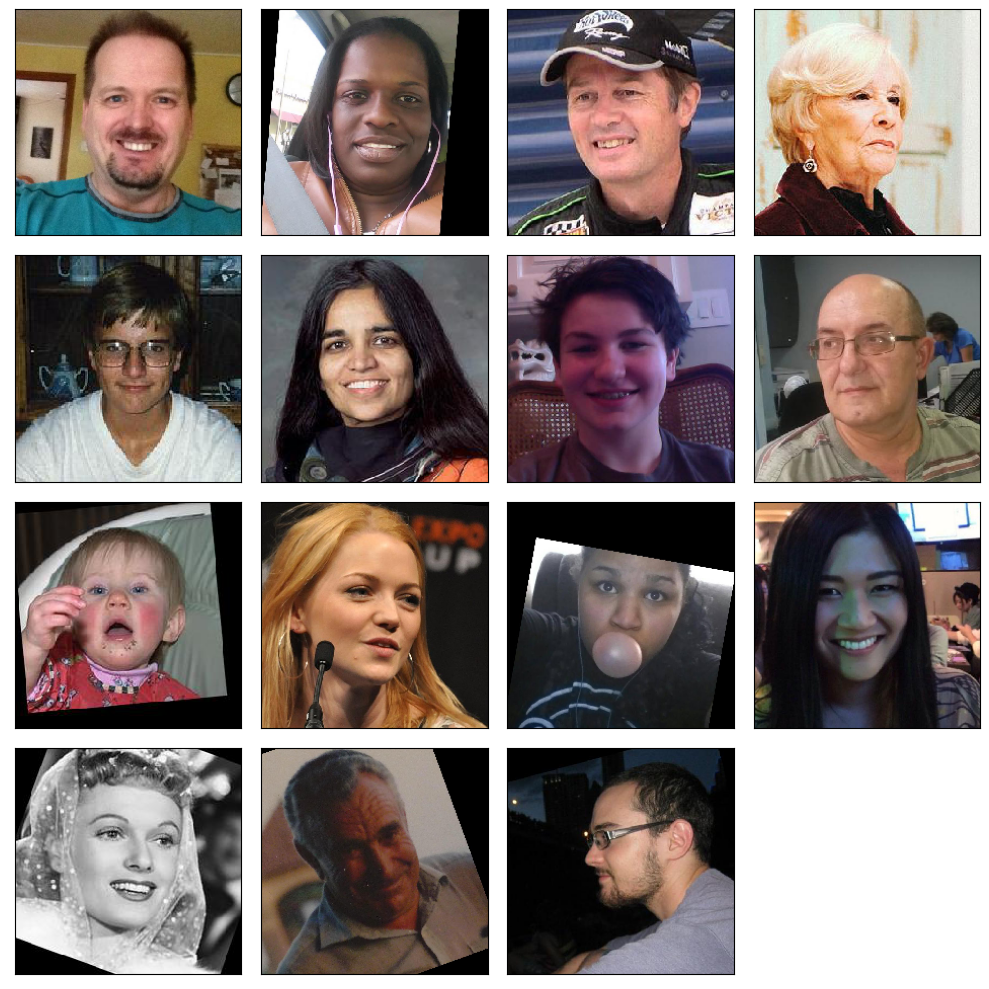

In [3]:
features, target = next(train_gen_flow)

# display 15 images
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [4]:
display(labels)

file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]

In [5]:
label_mix = labels.copy()
underage_target = label_mix[label_mix['real_age'] < 21]['file_name'].count()
overage_target = label_mix[label_mix['real_age'] >= 21]['file_name'].count()
print('Underage Customers:', underage_target, '\nCustomers over the Legal Age:', overage_target)

Underage Customers: 2054 
Customers over the Legal Age: 5537


In [6]:
fig = px.histogram(
                  labels['real_age'], 
                  title="Target Distribution<br><sup>Age</sup>",
                  labels={
                     "value": "Customer's Age",
                 })

fig.update_layout(
    yaxis_title="Frequency",
    showlegend=False,
    #legend_title="Legend",
    font=dict(
        family="Avenir",
        size=14,
        color="Black"
    )
)
fig.show()

In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
labels.describe()

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

### Findings

**`Images:`**

- From our data exploration, we see possible model training 'impacts' from looking at various image samples, these include:
    - Depth, Angles, Brigthness/Contrast, Saturation/Sharpness, Lighting, Noise (missing backgrounds or tons of objects behind the subject for example)
    - Additonal image variability comes through 1) photo quality (selfie vs. image taken by someone else vs. a photo of a photo), 2) objects on the subject's face (beanies, hats, glasses), and 3) the color quality of the images (greyscale vs. color)

**`Labels:`**

- Looking at the labels/targets, we see data distribution being largely skewed towards a category we will call 'over the legal drinking age' opening the door to possible class imbalances 
    - 27% of the dataset is allocated to the 'underage' category
    - Imbalance possibility given 'over the age' magnitude (double) compared to the underage total
    - No perceived missing values or NaNs (data contained at a range of ages 1-100)

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Well done!

</div>

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    """
    Loads the training portion of the dataset from the given path.
    """

    labels = pd.read_csv(path + 'labels.csv')  # Load labels using the path variable

    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1 / 255,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        zoom_range=0.2,
        height_shift_range=0.2
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',  # Use path variable to define directory
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',  # Regression task
        subset='training',
        seed=12345
    )

    return train_datagen_flow
    return train_datagen_flow

In [11]:
def load_test(path):
    """
    Loads the validation/test portion of the dataset from the given path.
    """

    labels = pd.read_csv(path + 'labels.csv')  # Load labels using the path variable

    test_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale=1 / 255
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',  # Use path variable to define directory
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',  # Regression task
        subset='validation',
        seed=12345
    )

    return test_datagen_flow

<div class="alert alert-danger">
<b>Reviewer's comment V1</b>

Good job! But:
    
1. You should create variable `labels` inside each of the functions above. If you create this variable outside the function, your code will fail because this variable won't be available in your script. And you should use variable `path` to read this dataset like this: `pd.read_csv(path + 'labels.csv')`
2. To write a path to directory you should use variable `path` like this: `directory=path + 'final_files/'`

</div>

In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, 
                  loss='mse',
                  metrics=['mae'])

    return model

In [13]:
def train_model(model, 
                train_data, 
                test_data,
                batch_size=None, 
                epochs=20,
                steps_per_epoch=None, 
                validation_steps=None):
    

    """
    Trains the model given the parameters
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

- Epoch 1/20
2023-10-22 19:31:39.356090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-22 19:31:40.092646: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 79s - **loss: 317.6967 - mae: 13.2098 - val_loss: 975.6401 - val_mae: 26.3546**

- Epoch 2/20
190/190 - 63s - **loss: 137.6697 - mae: 8.9437 - val_loss: 779.7155 - val_mae: 22.6731**

- Epoch 3/20
190/190 - 63s - **loss: 122.1128 - mae: 8.4115 - val_loss: 440.3505 - val_mae: 15.7010**

- Epoch 4/20
190/190 - 63s - **loss: 107.9151 - mae: 7.9203 - val_loss: 158.8830 - val_mae: 9.5444**

- Epoch 5/20
190/190 - 63s - **loss: 97.6936 - mae: 7.5546 - val_loss: 165.5535 - val_mae: 9.4506**

- Epoch 6/20
190/190 - 63s - **loss: 89.3001 - mae: 7.2656 - val_loss: 214.0707 - val_mae: 10.8097**

- Epoch 7/20
190/190 - 62s - **loss: 83.2525 - mae: 6.9945 - val_loss: 123.3681 - val_mae: 8.7813**

- Epoch 8/20
190/190 - 63s - **loss: 75.7391 - mae: 6.7029 - val_loss: 81.6724 - val_mae: 7.0492**

- Epoch 9/20
190/190 - 63s - **loss: 76.6568 - mae: 6.7153 - val_loss: 97.6928 - val_mae: 7.4303**

- Epoch 10/20
190/190 - 64s - **loss: 69.3067 - mae: 6.3775 - val_loss: 104.0298 - val_mae: 7.3718**

- Epoch 11/20
190/190 - 64s - **loss: 67.3927 - mae: 6.3129 - val_loss: 97.6250 - val_mae: 7.5635**

- Epoch 12/20
190/190 - 64s - **loss: 63.4414 - mae: 6.1070 - val_loss: 119.1421 - val_mae: 7.9010**

- Epoch 13/20
190/190 - 64s - **loss: 60.3117 - mae: 5.9699 - val_loss: 112.0962 - val_mae: 7.9066**

- Epoch 14/20
190/190 - 63s - **loss: 59.5610 - mae: 5.9343 - val_loss: 97.3579 - val_mae: 7.3993**

- Epoch 15/20
190/190 - 64s - **loss: 55.1537 - mae: 5.6967 - val_loss: 116.1927 - val_mae: 7.7342**

- Epoch 16/20
190/190 - 64s - **loss: 51.7438 - mae: 5.5317 - val_loss: 84.1817 - val_mae: 6.9431**

- Epoch 17/20
190/190 - 63s - **loss: 51.2082 - mae: 5.5052 - val_loss: 96.8386 - val_mae: 7.3405**

- Epoch 18/20
190/190 - 63s - **loss: 49.8366 - mae: 5.4189 - val_loss: 93.6827 - val_mae: 7.3418**

- Epoch 19/20
190/190 - 63s - **loss: 53.5766 - mae: 5.5839 - val_loss: 93.1571 - val_mae: 7.4434**

- Epoch 20/20
190/190 - 63s - **loss: 45.9040 - mae: 5.1792 - val_loss: 77.1441 - val_mae: 6.5967**


WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 7s - loss: 77.1441 - mae: 6.5967
**`Test MAE: 6.5967`**

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Good job!

</div>

## Conclusions

**`Age Prediction for Alcoholic Sales:`**

- After leveraging the ResNet50 architecture to analyze customer images and choosing optimal parameters, we are able to get to the target MAE of less than 8. 
    - With that said, while computer vision may be able to help the customer in this case, given the heightened risk and sensitivity of selling alcohol to people under the legal age along with the significant fines and problems that come with that, it would be **highly advisable** to incorporate another layer of verification at the very least if this is to be deployed (along with more in-depth tuning/optimization). Good Seed will have to weight the pros and cons of having such system in place and truly relying on it. Will Good Seed be comfortable not having a truly accurate system? predicting someone's age at 20 vs 21 can make a whole world of difference in this scenario...not much room for error here...
    
*`There is a reason afterall that we don't see this at Whole Foods or other, much larger 'supermarkets'.`*

**`Other Practical Usage:`**
    
- Aside from the possibility of leveraging our computer vision model to predict a person's age when it comes to selling alcohol (assuming this is a U.S. based chain so legal age = 21) Good Seed should be able to leverage our computer vision model to:

    1) categorize fruits and vegetables that are usually weighted and looked up by consumers,
    
    2) keep track of / monitor items that might not have been scanned (either categorized as losses or theft, up to the business on how to pivot),
    
    3) potentially track facial movement to predict emotions / emotional state and comparing that data to checkout carts (could open up a new path to advertise food pairings to individual and recurring shoppers) <-- would be extra interesting comparing this information to the time of day / month / year and weather to paint a truly personalized picture per shopper.
    
    
- These other usage options may be more beneficial given they don't come with legal difficulties and there is slightly more room for error. A banana is usually going to look like a banana, it won't suddenly appear with aviator sunglasses and a beanie.

<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Great work!

</div>

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training